# RAPORT 3

In [50]:
using Plots
using DataFrames

## Definiowanie funkcji

* s: People who are “susceptible”, that is, capable of contracting the disease if they come into contact with someone who is infected.
* i: People who are “infectious”, that is, capable of passing along the disease if they come into contact with someone susceptible.
* r: People who are “recovered”. In the basic version of the model, people who have recovered are considered to be no longer infectious and immune to reinfection. That is a reasonable model for some diseases, but not for others, so it should be on the list of assumptions to reconsider later.

\begin{equation}
\begin{aligned}
\frac{ds}{dt} &= -β si \\
\frac{di}{dt} &= β si - γ i \\
\frac{dr}{dt} &= γ i
\end{aligned}
\end{equation}

In [233]:

# Initial state - stan początkowy w funkcji make_system
function initial_state()
    s = 99.0
    i = 1.0
    r = 0.0
    d = 0.0
    total = s + i + r + d
    s /= total
    i /= total
    r /= total
    d /= total
    return s, i, r, d
end

#  Funkcja tworząca słownik do symulacji
function make_system(β, γ, θ)
    s, i, r, d = initial_state()
    t_end = 7 * 20  # koniec symulacji w dniach
    return Dict(:init_s => s, :init_i => i, :init_r => r,
        :init_d => d, :t_end => t_end,
        :β => β, :γ => γ, :θ => θ)
end

# Funkcja do dodania immunizacji
function add_immunization(system, fraction)
    system[:init_s] -= fraction
    system[:init_r] += fraction
end

# Przeście przez jeden okres
function update_state(s, i, r, d, system)
    β = system[:β]
    γ = system[:γ]
    θ = system[:θ]

    infected = β * i * s
    recovered = γ * i
    dead = θ*(i^2)

    s -= infected
    i += infected - recovered - dead
    r += recovered
    d += dead
    return s, i, r, d
end

# Główna funkcja do stworzenia symulacji
function run_simulation(system, update_func)
    s, i, r, d = system[:init_s], system[:init_i], system[:init_r], system[:init_d]
    t_end = system[:t_end]

    S = [s]
    I = [i]
    R = [r]
    D = [d]

    for t in 1:t_end
        s, i, r, d = update_func(s, i, r, d, system)
        push!(S, s)
        push!(I, i)
        push!(R, r)
        push!(D, d)
    end

    return S, I, R, D
end

### Funkcje do plotowania
function plot_results(S, I, R, D, label)
    p = plot(0:length(S)-1, S, label="Susceptible ($label)", linestyle=:dash)
    plot!(p, 0:length(I)-1, I, label="Infected ($label)")
    plot!(p, 0:length(R)-1, R, label="Recovered ($label)", linestyle=:dot)
    plot!(p, 0:length(D)-1, D, label="Dead ($label)", linestyle=:dot)
    xlabel!("Time (days)")
    ylabel!("Fraction of population")
    title!("SIR Model Simulation")
    display(p)
end

function calc_total_infected(results)
    s_0 = results[1]
    s_end = results[end]
    return s_0 - s_end
end


### Funkcje do analizy wrażliwości
function sweep_immunity(fraction_array, β, γ, θ)
    sweep = Dict()

    for fraction in fraction_array
        system = make_system(β, γ, θ)
        add_immunization(system, fraction)
        S, I, R, D = run_simulation(system, update_state)
        sweep[fraction] = -calc_total_infected(R)
    end

    return sweep
end

### Funkcje do analizy wrażliwości
function sweep_immunity_2(fraction_array, β, γ, θ)
    sweep = Dict()

    for fraction in fraction_array
        system = make_system(β, γ, θ)
        add_immunization(system, fraction)
        S, I, R, D = run_simulation(system, update_state)
        sweep[fraction] = -calc_total_infected(D)
    end

    return sweep
end


function sweep_beta(beta_array, γ, θ)
    sweep = Dict()
    for β in beta_array
        system = make_system(β, γ, θ)
        S, I, R, D = run_simulation(system, update_state)
        sweep[β] = calc_total_infected(S)
    end
    return sweep
end

function sweep_parameters(beta_array, gamma_array, θ)
    frame = Dict()
    for γ in gamma_array
        frame[γ] = sweep_beta(beta_array, γ, θ)
    end
    return frame
end

function plot_contour(frame, beta_array, gamma_array)
    Z = [frame[γ][β] for γ in gamma_array, β in beta_array]
    contourf(beta_array, gamma_array, Z)
    xlabel!("Recovery rate (γ)")
    ylabel!("Contact rate (β)")
    title!("Contour plot, fraction infected")
end



plot_contour (generic function with 1 method)

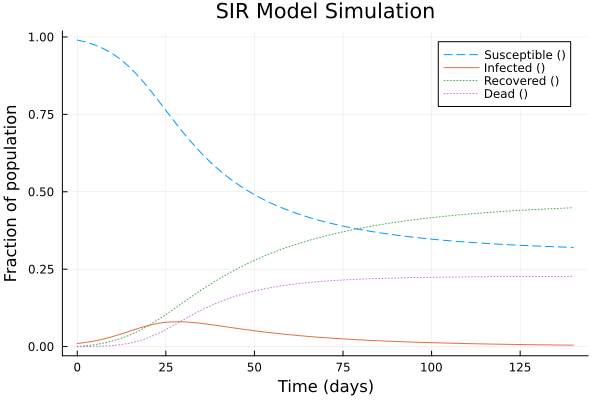

In [238]:
# Główna część programu
i = 0 
β = 1 / 4
γ = 1 / 10
θ = 1
system = make_system(β, γ, θ)
add_immunization(system, i)
S, I, R, D = run_simulation(system, update_state)
plot_results(S, I, R, D, "")


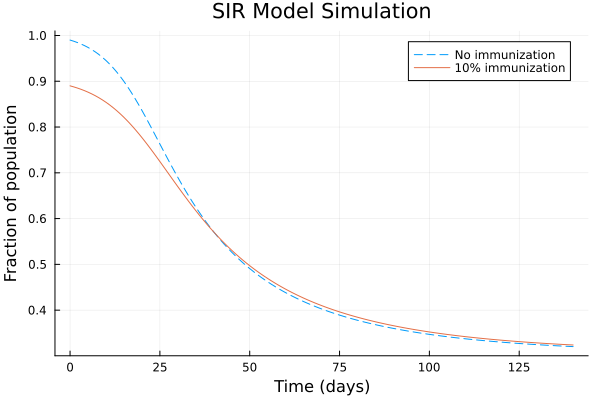

In [239]:
i = 0.1  # procent zaszczepionej populacji
system2 = make_system(β, γ, θ)
add_immunization(system2, i)
S2, I2, R2, D2 = run_simulation(system2, update_state)

p1 = plot(0:length(S)-1, S, label="No immunization", linestyle=:dash)
plot!(p1, 0:length(S2)-1, S2, label="10% immunization")
xlabel!(p1, "Time (days)")
ylabel!(p1, "Fraction of population")
title!(p1, "SIR Model Simulation")
display(p1)


Total infected (no immunization): 0.6696511174653006
Total infected (10% immunization): 0.5661395632551195


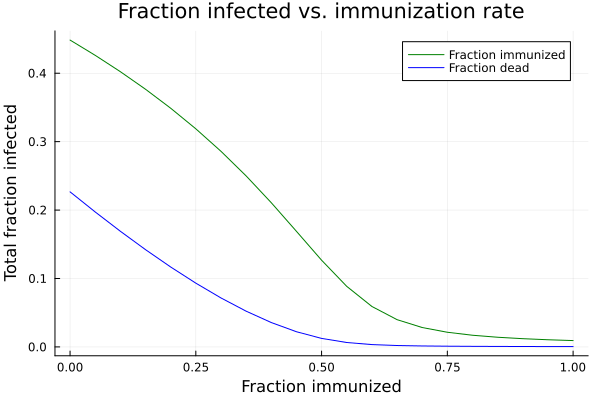

In [240]:

total_infected_no_immunization = calc_total_infected(S)
total_infected_immunization = calc_total_infected(S2)
total_dead_no_immunization = calc_total_infected(D)
total_dead_immunization = calc_total_infected(D2)

println("Total infected (no immunization): $total_infected_no_immunization")
println("Total infected (10% immunization): $total_infected_immunization")

fraction_array = range(0, stop=1, length=21)
infected_dict = sweep_immunity(fraction_array, β, γ, θ)
infected_values = [value for value in values(sort(infected_dict))]

p2 = plot(fraction_array, infected_values, label="Fraction immunized", color=:green)

fraction_array = range(0, stop=1, length=21)
infected_dict = sweep_immunity_2(fraction_array, β, γ, θ)
infected_values = [value for value in values(sort(infected_dict))]

plot!(fraction_array, infected_values, label="Fraction dead", color=:blue)

xlabel!(p2, "Fraction immunized")
ylabel!(p2, "Total fraction infected")
title!(p2, "Fraction infected vs. immunization rate")
display(p2)

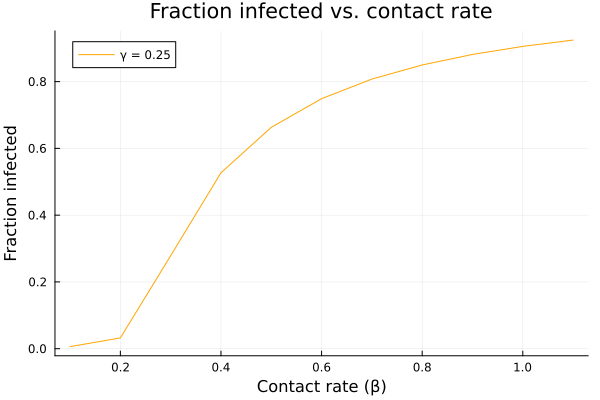

In [241]:
beta_array = range(0.1, stop=1.1, length=11)
γ = 0.25
infected_dict = sweep_beta(beta_array, γ, θ)
infected_values = [value for value in values(sort(infected_dict))]

p3 = plot(beta_array, infected_values, label="γ = $γ", color=:orange)
xlabel!(p3, "Contact rate (β)")
ylabel!(p3, "Fraction infected")
title!(p3, "Fraction infected vs. contact rate")
display(p3)


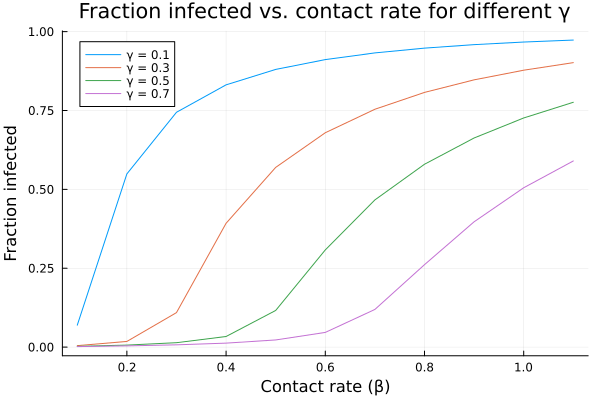

In [242]:
gamma_array = range(0.1, stop=0.7, length=4)

p4 = plot()
for γ in gamma_array
    infected_dict = sweep_beta(beta_array, γ, θ)
    infected_values = [value for value in values(sort(infected_dict))]
    plot!(p4, beta_array, infected_values, label="γ = $γ")
end

xlabel!(p4, "Contact rate (β)")
ylabel!(p4, "Fraction infected")
title!(p4, "Fraction infected vs. contact rate for different γ")
display(p4)

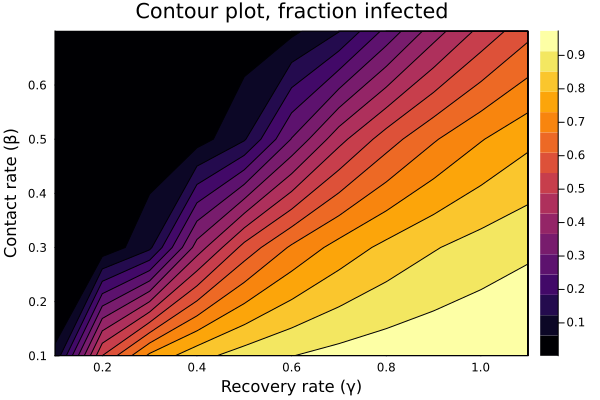

In [243]:
frame = sweep_parameters(beta_array, gamma_array, θ)

p5 = plot_contour(frame, beta_array, gamma_array)
display(p5)